# Creating multidimension timeseries.

## Load packages.

In [30]:
require(data.table)
require(deSolve)
require(magrittr)

require(ggplot2)


## Function to generate simulations.

In [2]:
# Create a multivariate function with specified properties:
#   tmax: maximum time
#   multiplicities: number of correlations each parameter has
#   degrees: polynomial degree of each parameter
#   dimension: the dimension of the output
#   returns a multivariate function of the vector of parameters and time
makeGenerator <- function(multiplicities, degrees, dimension) {

    single <- function(degree) {
      x0 <- runif(1)
      z0 <- runif(1)
      function(x) {
          if (x < x0)
              0
          else
              z0 * (x - x0)^degree
      }
    }
  
    locations <- lapply(multiplicities, function(m) sample(1:dimension, m))
    functions <- lapply(degrees, single)
    
    start <- runif(dimension, -0.25, 0.75)
    coefs <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)    
    shift <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)
    
    function(x, ts) {
        z <- rep(0, dimension)
        for (i in 1:length(locations))
            for (j in locations[[i]])
                z[j] <- z[j] + functions[[i]](x[i])
        ode(start, ts, function(t, y, params) {list((coefs %*% y) * z * (1 - ((shift %*% y) * z)))})
    }
    
}


## Example.

Create an example function with three input dimensions and three output dimensions. The first two input parameters affect two of the output dimensions, and the third affects all output dimensions. The first parameter involves a discontinuity in the timeseries's dependence on the parameter, the second parameter involves a discontinuity in the derivative, and the third parameter involves a discontinuity in the second derivative.

In [22]:
f <- makeGenerator(c(2, 2, 3), c(0, 1, 2), 3)

Evaluate at some times.

In [23]:
ts <- seq(0, 10, 0.5)

Run a single simulation.

In [24]:
runCase <- function(case) {
  x <- runif(3)
  y <- f(x, ts)
  data.frame(case=factor(case), x1=x[1], x2=x[2], x3=y[3], t=ts, y1=y[, 2], y2=y[, 3], y3=y[, 4])
}

Run multiple cases.

In [25]:
ys <- NULL
for (i in 1:10)
  ys <- rbind(ys, runCase(i))

In [26]:
ys %>% head

case,x1,x2,x3,t,y1,y2,y3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.04187908,0.7832554,1,0.0,-0.06485568,0.03466136,0.02537234
1,0.04187908,0.7832554,1,0.5,-0.06485568,0.03466136,0.02537234
1,0.04187908,0.7832554,1,1.0,-0.06485568,0.03466136,0.02537234
1,0.04187908,0.7832554,1,1.5,-0.06485568,0.03466136,0.02537234
1,0.04187908,0.7832554,1,2.0,-0.06485568,0.03466136,0.02537234
1,0.04187908,0.7832554,1,2.5,-0.06485568,0.03466136,0.02537234


Make some plots.

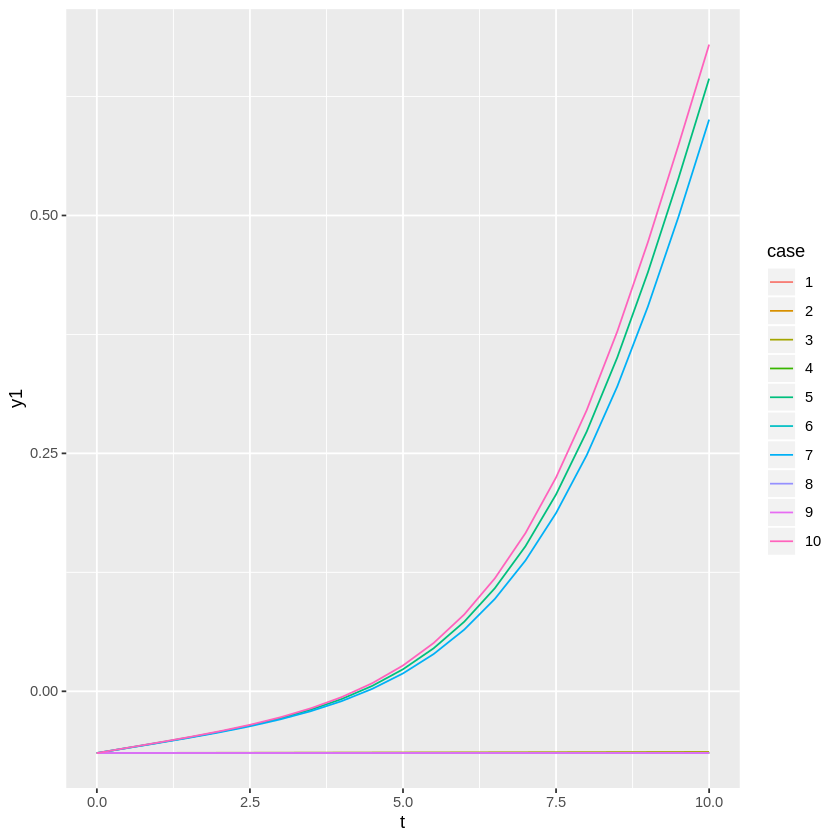

In [27]:
ggplot(ys, aes(x=t, y=y1, color=case)) + geom_line()

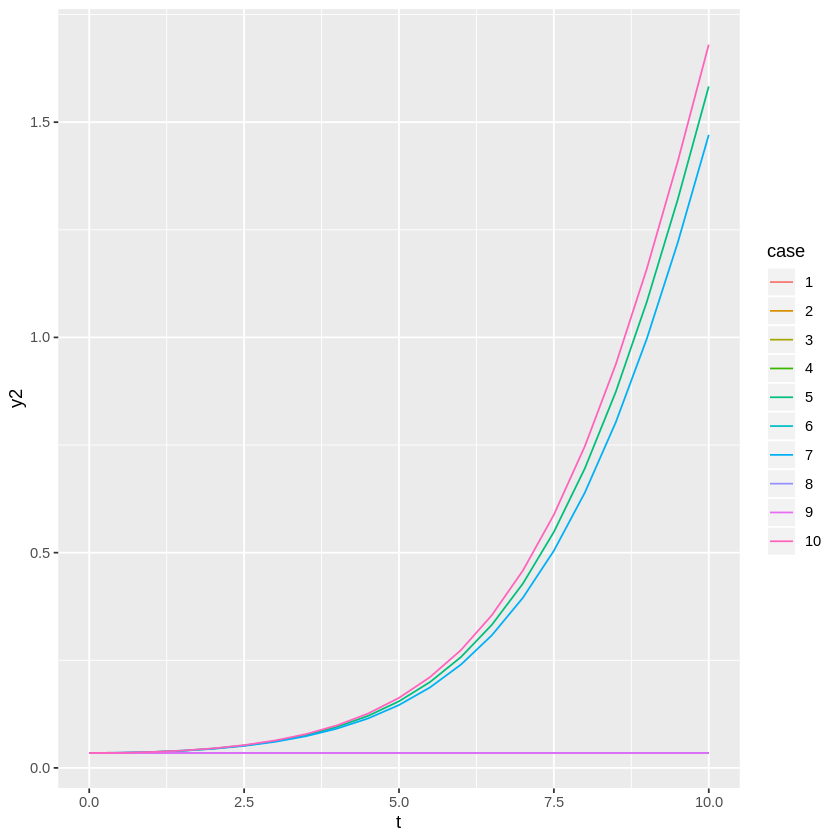

In [28]:
ggplot(ys, aes(x=t, y=y2, color=case)) + geom_line()

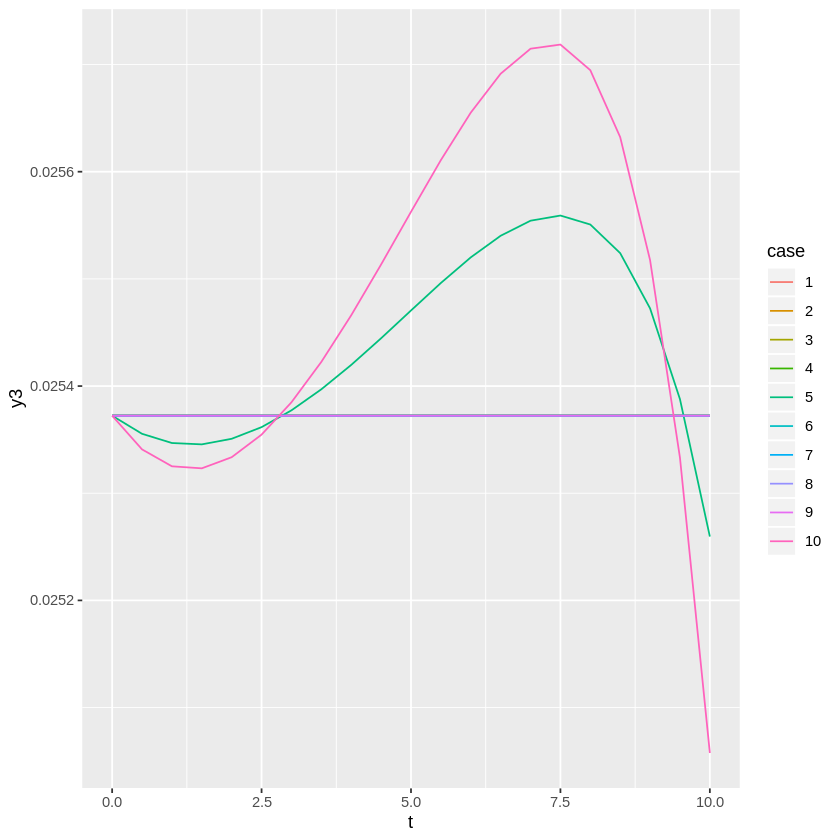

In [29]:
ggplot(ys, aes(x=t, y=y3, color=case)) + geom_line()

## How to use this.

The result of calling `makeGenerator` is a random function of input parameters `x` and times `t` that returns a multivariate timeseries `y`. The shape of that timeseries has nonlinear dependencies and correlations for the `x` parameters.

The sensitivity-analysis problem is to quantify the dependence of `y(t|x)` on the parameters `x`.

Our goal is to adaptively sample `x` in order to create a "phase diagram" delimiting different local patterns of sensitivity of `y(t|x)` on `x`.